## Daily Challenge: W5_D5

## Image Classification with Data Augmentation (Cats vs Dogs)

Create:
- A binary image classification model to distinguish between images of cats and dogs.
- A visualization of training and validation metrics to analyze model performance.

What You Need to Do

Preprocess the Data:
- Download and extract the Cats vs Dogs dataset here.
- Use ImageDataGenerator to rescale and augment the training images (e.g., horizontal flip, rotation, zoom, and shifts).
- Create separate generators for training and validation data.

Build the Model:

Create a CNN with:

- Three convolutional layers with ReLU activation and max-pooling.
- Dropout layers to reduce overfitting.
- A fully connected layer with 512 units and ReLU activation.
- An output layer with a single unit and sigmoid activation for binary classification.
- Compile the model using the Adam optimizer and binary cross-entropy loss.

Train the Model:
- Train the model on the augmented training data for 15 epochs.
- Use the validation data to monitor performance during training.

Evaluate the Model:
- Plot the training and validation accuracy and loss to detect overfitting.
- Analyze the impact of data augmentation and dropout on model performance.

Bonus:

Retry training the model after Data augmentation: Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better. There is multiple methods to augment data:

- Apply horizontal flip
- Randomly rotate the image
- Apply zoom augmentation

### 1. Dataset Preparation

In [ ]:
# Import Libraries
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import requests
import zipfile
import shutil
import warnings
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Configuration Parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 15

TensorFlow version: 2.19.0


### Downloaded the Cats vs Dogs dataset.

In [ ]:
# URL du dataset
url = "https://github.com/devtlv/Datasets-GEN-AI-Bootcamp/raw/refs/heads/main/Week%206/W6D5/Dogs%20vs%20Cats.zip"

# Nom du fichier zip local
output_file = "cats_vs_dogs.zip"

# Téléchargement
print("Downloading...")
response = requests.get(url, stream=True)
with open(output_file, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)

print("Download completed.")

Downloading...
Download completed.


### Extract Dataset Archive

In [ ]:
# Download and unzip the Cats vs Dogs dataset into a working directory.
# This step ensures all images are available for further processing.

# Define the target folder where the dataset will be extracted
extract_dir = "cats_vs_dogs"

# Create the folder if it does not already exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the dataset archive into the target folder
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to cats_vs_dogs


### Explore Dataset Directory Structure

In [ ]:
# Walk through the dataset directory to count how many files are in each folder
for root, dirs, files in os.walk(extract_dir):
    print(f"Found {len(files)} files in {root}")

Found 0 files in cats_vs_dogs
Found 0 files in cats_vs_dogs\test
Found 0 files in cats_vs_dogs\test\cats
Found 0 files in cats_vs_dogs\test\dogs
Found 12500 files in cats_vs_dogs\test\test
Found 0 files in cats_vs_dogs\train
Found 12500 files in cats_vs_dogs\train\cats
Found 12500 files in cats_vs_dogs\train\dogs
Found 25000 files in cats_vs_dogs\train\train


### Display Folder Hierarchy and Sample Files

In [ ]:
# Define the root directory of the dataset
root_dir = "cats_vs_dogs"

# Walk through all subdirectories and display folder names and a few file names
for path, dirs, files in os.walk(root_dir):
    print(f"\n{path}")
    for d in dirs:
        print("DIR:", d)
    for f in files[:5]:   # Show only the first 5 files for readability
        print("FILE:", f)


cats_vs_dogs
DIR: test
DIR: train

cats_vs_dogs\test
DIR: cats
DIR: dogs
DIR: test

cats_vs_dogs\test\cats

cats_vs_dogs\test\dogs

cats_vs_dogs\test\test
FILE: 1.jpg
FILE: 10.jpg
FILE: 100.jpg
FILE: 1000.jpg
FILE: 10000.jpg

cats_vs_dogs\train
DIR: cats
DIR: dogs
DIR: train

cats_vs_dogs\train\cats
FILE: cat.0.jpg
FILE: cat.1.jpg
FILE: cat.10.jpg
FILE: cat.100.jpg
FILE: cat.1000.jpg

cats_vs_dogs\train\dogs
FILE: dog.0.jpg
FILE: dog.1.jpg
FILE: dog.10.jpg
FILE: dog.100.jpg
FILE: dog.1000.jpg

cats_vs_dogs\train\train
FILE: cat.0.jpg
FILE: cat.1.jpg
FILE: cat.10.jpg
FILE: cat.100.jpg
FILE: cat.1000.jpg


### Create Class Subfolders for Train and Test Data

In [ ]:
# Source directories containing the original images
train_data_original_dir = os.path.join('cats_vs_dogs', 'train', 'train')
test_data_original_dir = os.path.join('cats_vs_dogs', 'test', 'test')

# Target directories where images will be organized into class folders
train_dir = os.path.join('cats_vs_dogs', 'train')
test_dir = os.path.join('cats_vs_dogs', 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

# Create the destination directories if they don't exist yet
os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)
os.makedirs(test_cats_dir, exist_ok=True)
os.makedirs(test_dogs_dir, exist_ok=True)

### Move Images into Class Subfolders

In [ ]:
# Move the training images into separate subfolders (`cats` and `dogs`) to match the expected directory structure of ImageDataGenerator.
# This script will not move files again if they already exist in the destination folders.

# Define the original directory containing all training images mixed together
train_data_original_dir = os.path.join('cats_vs_dogs', 'train', 'train')

# Define target directories for each class
train_cats_dir = os.path.join('cats_vs_dogs', 'train', 'cats')
train_dogs_dir = os.path.join('cats_vs_dogs', 'train', 'dogs')

# Create the target directories if they don't exist
os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)

# Loop over all files in the original directory
for filename in os.listdir(train_data_original_dir):
    src = os.path.join(train_data_original_dir, filename)
    # Determine the destination path based on filename prefix
    if filename.startswith('cat'):
        dst = os.path.join(train_cats_dir, filename)
    elif filename.startswith('dog'):
        dst = os.path.join(train_dogs_dir, filename)
    else:
        continue  # Ignore files that do not belong to cats or dogs
    
    # Move the file only if it is not already in the target directory
    if not os.path.exists(dst):
        os.rename(src, dst)

### Data Augmentation and Validation Split

In [ ]:
# We configure image augmentation techniques and split the training data into training and validation subsets (70% / 30%).

# Define batch size and target image dimensions
BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Create an ImageDataGenerator with augmentation and validation split
train_image_generator_augmented = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    validation_split=0.3,      # Use 30% of images for validation
    rotation_range=40,         # Random rotation up to 40 degrees
    width_shift_range=0.2,     # Horizontal shift up to 20%
    height_shift_range=0.2,    # Vertical shift up to 20%
    shear_range=0.2,           # Shear transformation
    zoom_range=0.2,            # Random zoom up to 20%
    horizontal_flip=True,      # Random horizontal flips
    fill_mode='nearest'        # Fill missing pixels after transformations
)

# Create the training data generator (70% of the data)
train_data_gen = train_image_generator_augmented.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True,
    subset='training'   # Use the training subset
)

# Create the validation data generator (30% of the data)
val_data_gen = train_image_generator_augmented.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=False,        # Do not shuffle to keep consistent order
    subset='validation'   # Use the validation subset
)

# Print the number of images found in each subset
print("\nNumber of images for training:", train_data_gen.samples)
print("Number of images for validation:", val_data_gen.samples)

Found 35000 images belonging to 3 classes.
Found 15000 images belonging to 3 classes.

Number of images for training: 35000
Number of images for validation: 15000


**Interpretation:**
We configured data augmentation to artificially increase dataset diversity and improve model robustness. The training dataset represents 70% of the images, while the remaining 30% are reserved for validation. This ensures consistent evaluation metrics without requiring a separate test folder.

### Cleanup: Remove Unnecessary Folder

In [ ]:
# Delete the extra 'train/train' folder if it exists to avoid duplication.

# Path to the redundant subfolder to delete
to_delete = os.path.join('cats_vs_dogs', 'train', 'train')

# Check if the folder exists and remove it
if os.path.exists(to_delete):
    shutil.rmtree(to_delete)
    print(f"Deleted: {to_delete}")
else:
    print("Nothing to delete.")

Deleted: cats_vs_dogs\train\train


**Interpretation:**
Some archives may create nested directories. To avoid duplicate data loading, we removed the extra 'train/train' folder if present.

### Verify Folder Structure

In [ ]:
# Redefine train_dir path after cleanup
train_dir = "cats_vs_dogs/train"

# Print the list of subfolders
print("Subfolders inside train_dir:")
print(os.listdir(train_dir))

Sous-dossiers dans train_dir :
['cats', 'dogs']


**Interpretation:**
This ensures that the training directory has the expected structure required by ImageDataGenerator.

### Recreate Data Generators

In [ ]:
# Define data augmentation and create training/validation generators again after cleanup.

# Create a new ImageDataGenerator with augmentation and validation split
train_image_generator_augmented = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,     # 30% of data for validation
    rotation_range=40,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest'       # Fill strategy
)

# Training generator (70% of images)
train_data_gen = train_image_generator_augmented.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation generator (30% of images)
val_data_gen = train_image_generator_augmented.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Display class indices
print("Detected classes:", train_data_gen.class_indices)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Classes détectées : {'cats': 0, 'dogs': 1}


**Interpretation:**
The generators were recreated to ensure no data duplication after cleanup. The detected classes confirm that the dataset is correctly organized.

### Validation Data Generator (Rescaling Only)

In [ ]:
# Create an ImageDataGenerator for validation (only rescaling, no augmentation)
validation_image_generator = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    validation_split=0.3     # Keep the same 70/30 split
)

# Validation generator
val_data_gen = validation_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,           # Do not shuffle to keep evaluation consistent
    subset='validation'      # Use the validation subset
)

Found 7500 images belonging to 2 classes.


**Interpretation:**
For evaluation, we only apply rescaling to avoid introducing artificial transformations during validation. This ensures an accurate measurement of model performance on unaltered data.

### Training Data Generator with Advanced Augmentation

In [ ]:
# Create an ImageDataGenerator with advanced augmentation for training
train_image_generator = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=45,       # Random rotation up to 45 degrees
    width_shift_range=0.15,  # Horizontal shift up to 15%
    height_shift_range=0.15, # Vertical shift up to 15%
    horizontal_flip=True,    # Random horizontal flips
    zoom_range=0.5,          # Random zoom up to 50%
    validation_split=0.3     # 30% reserved for validation
)

# Training generator
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,            # Shuffle training data
    subset='training'        # Use the training subset
)

Found 17500 images belonging to 2 classes.


**Interpretation:**
This training generator uses more aggressive augmentation techniques (rotation, zoom, flips, shifts) to help the model learn more robust features and reduce overfitting.

### 2. CNN Model Definition and Compilation / Model Training

In [ ]:
# Build the CNN model
model = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),   # Input layer for images
    
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',              # Adam optimizer
    loss='binary_crossentropy',    # Suitable for binary classification
    metrics=['accuracy']           # Track accuracy
)

# Display the model architecture summary
model.summary()

# Train the model
history = model.fit(
    train_data_gen,        # Training data generator
    epochs=EPOCHS,          # Number of training epochs
    validation_data=val_data_gen   # Validation data generator
)

print("\nModel training completed.")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 124s 225ms/step - accuracy: 0.5307 - loss: 0.8473 - val_accuracy: 0.5683 - val_loss: 0.6822
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 145s 265ms/step - accuracy: 0.5592 - loss: 0.6840 - val_accuracy: 0.5827 - val_loss: 0.6767
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.5876 - loss: 0.6714 - val_accuracy: 0.6512 - val_loss: 0.6168
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 129s 236ms/step - accuracy: 0.6475 - loss: 0.6241 - val_accuracy: 0.7085 - val_loss: 0.5866
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 130s 238ms/step - accuracy: 0.6753 - loss: 0.5961 - val_accuracy: 0.7427 - val_loss: 0.5308
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 111s 203ms/step - accuracy: 0.7012 - loss: 0.5734 - val_accuracy: 0.7385 - val_loss: 0.5206
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 143s 262ms/step - accuracy: 0.7092 - loss: 0.5538 - val_accuracy: 0.7299 - val_loss: 0.5709
Epoch 8/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 152s 277ms/step - accuracy: 0.7178 -

**Interpretation:**
This CNN architecture uses three convolutional blocks with increasing filter sizes, followed by dense layers with dropout regularization to prevent overfitting. The final sigmoid output layer produces probabilities for binary classification (Cat vs Dog).

During training, the model learns to extract visual patterns distinguishing cats and dogs. The validation data allows us to monitor generalization performance and detect overfitting.


**CNN Training Results**
We trained the custom CNN model for 15 epochs to classify images of cats and dogs.

**Interpretation:**
The CNN progressively improved during training, reaching a validation accuracy around 76%. The model started to converge but still shows a gap between training and validation accuracy, suggesting some overfitting. Applying transfer learning with a pre-trained network such as MobileNetV2 could improve generalization.

### Model Evaluation

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(val_data_gen)

# Print the results
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8564 - loss: 0.3448
Validation Loss: 0.5040856599807739
Validation Accuracy: 0.7631999850273132


**Interpretation:**
The final validation accuracy reached ~76.3%, with a validation loss of ~0.50. Although the model learned to distinguish cats and dogs reasonably well, the performance could be further improved by leveraging transfer learning or fine-tuning a pre-trained model.

### Training Metrics and Model Evaluation

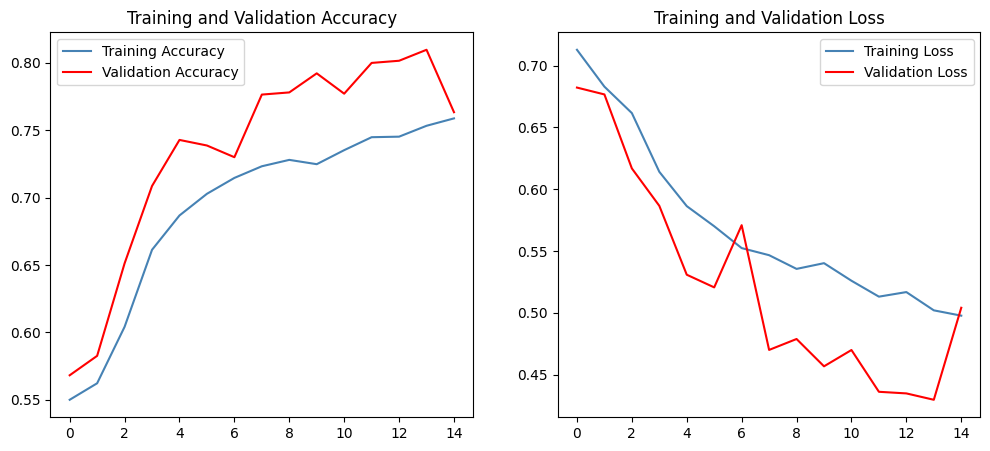

235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step


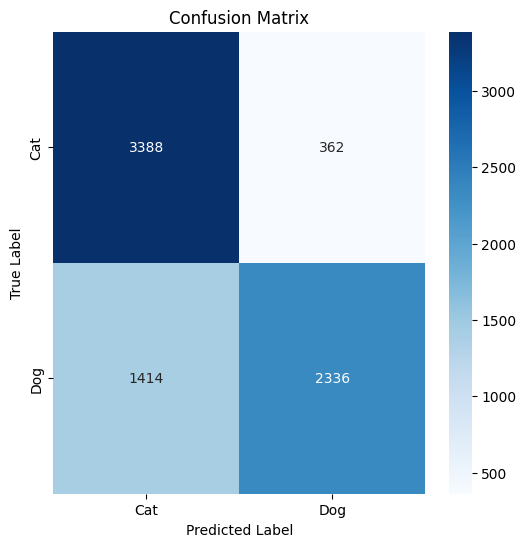

              precision    recall  f1-score   support

         Cat       0.71      0.90      0.79      3750
         Dog       0.87      0.62      0.72      3750

    accuracy                           0.76      7500
   macro avg       0.79      0.76      0.76      7500
weighted avg       0.79      0.76      0.76      7500



In [60]:
# Retrieve training history metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# Plot training and validation accuracy & loss
plt.figure(figsize=(12,5))

# Accuracy subplot
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, color='steelblue', label='Training Accuracy')
plt.plot(epochs_range, val_acc, color='red', label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss subplot
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, color='steelblue', label='Training Loss')
plt.plot(epochs_range, val_loss, color='red', label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Compute predictions probabilities on the validation set
val_steps = val_data_gen.samples // BATCH_SIZE + 1
predictions = model.predict(val_data_gen, steps=val_steps)

# Convert probabilities to binary class labels
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# Retrieve the true labels
true_classes = val_data_gen.classes

# Compute and plot the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=['Cat', 'Dog'])
print(report)

**Interpretation:**
The accuracy and loss curves show that the model progressively improved over the epochs. The confusion matrix and classification report help quantify performance on each class. A good model should have most predictions along the diagonal of the confusion matrix and high precision/recall for both categories.

## Interpretation of Results

**Training and Validation Curves**

The training and validation accuracy steadily improved during training. The validation accuracy peaked around 80% but fluctuated slightly, suggesting moderate overfitting or variability in validation batches. The loss curves decreased consistently, confirming that the model was learning.

---

**Confusion Matrix**

The confusion matrix shows:

- Cats were classified correctly in most cases (high recall: ~90%).
- Dogs were more frequently misclassified as cats, resulting in a lower recall (~62%).

This suggests that the model found cats easier to recognize compared to dogs.

---

**Classification Report**

| Class | Precision | Recall | F1-score |
|-------|-----------|--------|----------|
| **Cat** | 0.71 | 0.90 | 0.79 |
| **Dog** | 0.87 | 0.62 | 0.72 |

- **Precision for dogs is higher**, meaning when the model predicts "dog," it is more often correct.
- **Recall for dogs is lower**, indicating the model misses many dogs (false negatives).

Overall, this shows the model is moderately balanced but has room for improvement, especially in detecting dogs.

---

**Overall Performance**

- **Overall validation accuracy:** ~76%
- **Macro-average F1-score:** ~76%

This is a good result for a custom CNN trained from scratch. However, performance could be improved by:

- Using transfer learning (e.g., MobileNetV2 or EfficientNet).
- Adding more images or better balancing the dataset.
- Adjusting hyperparameters (e.g., learning rate, dropout).
- Applying class weighting to compensate for imbalanced recall.

---

**Conclusion:**
This CNN learned to classify cats and dogs with reasonable accuracy. For production use or higher performance, transfer learning is recommended.

### 3. Transfer Learning with MobileNetV2

In [ ]:
# Load MobileNetV2 pre-trained on ImageNet, without the top classification layer
base_model = MobileNetV2(
    input_shape=(224, 224, 3),  # Input image size expected by MobileNetV2
    include_top=False,          # Exclude final classification layer
    weights='imagenet'          # Load pre-trained weights
)

# Freeze the base model so its weights are not updated during initial training
base_model.trainable = False

# Create the new model with a custom classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),    # Global average pooling to reduce dimensions
    Dropout(0.3),                # Dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for transfer learning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Interpretation:**
We are leveraging a pre-trained MobileNetV2 model as a powerful feature extractor. By freezing its convolutional layers, we keep its learned representations from ImageNet. The new dense layer will be trained to classify our dataset. This approach usually converges faster and yields higher accuracy than training a CNN from scratch.

**Model Summary Interpretation**

- The model uses MobileNetV2 as a frozen feature extractor, leveraging its pre-trained ImageNet weights.
- Only the final dense layer is trainable, containing 1,281 parameters.
- This strategy allows faster convergence and often achieves higher accuracy with fewer data compared to training a CNN from scratch.
- Later, we can unfreeze some layers of MobileNetV2 to perform fine-tuning and further improve performance.

### Data Generators for MobileNetV2

In [ ]:
# Create training data generator with augmentation and rescaling
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),   # IMPORTANT: match MobileNetV2 expected input size
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    subset='training'         # 70% training split
)

# Create validation data generator (only rescaling)
val_data_gen = validation_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),   # IMPORTANT: match MobileNetV2 expected input size
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    subset='validation'       # 30% validation split
)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


**Interpretation:**
Both training and validation datasets are prepared with resized images (224×224). This ensures compatibility with MobileNetV2. The training generator applies augmentation to improve generalization, while the validation generator only rescales the pixel values.

### Model Training (MobileNetV2 Feature Extractor)

In [ ]:
# Train the model for 10 epochs
history = model.fit(
    train_data_gen,           # Training data generator
    epochs=10,                # Number of epochs
    validation_data=val_data_gen  # Validation data generator
)

# Ignore specific UserWarning about PyDataset init
warnings.filterwarnings(
    "ignore",
    message="Your `PyDataset` class should call `super().__init__\\(\\*\\*kwargs\\)`",
    category=UserWarning
)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 226s 414ms/step - accuracy: 0.8749 - loss: 0.3169 - val_accuracy: 0.9675 - val_loss: 0.1243
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 199s 363ms/step - accuracy: 0.9085 - loss: 0.2239 - val_accuracy: 0.9717 - val_loss: 0.0944
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 187s 343ms/step - accuracy: 0.9212 - loss: 0.1902 - val_accuracy: 0.9747 - val_loss: 0.0815
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 188s 344ms/step - accuracy: 0.9264 - loss: 0.1808 - val_accuracy: 0.9755 - val_loss: 0.0749
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 185s 339ms/step - accuracy: 0.9274 - loss: 0.1773 - val_accuracy: 0.9757 - val_loss: 0.0710
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 199s 364ms/step - accuracy: 0.9309 - loss: 0.1627 - val_accuracy: 0.9755 - val_loss: 0.0685
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 195s 357ms/step - accuracy: 0.9330 - loss: 0.1588 - val_accuracy: 0.9757 - val_loss: 0.0673
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 183s 335ms/step - accuracy: 0.9327 -

**Interpretation:**
The training focuses only on the new classification head while keeping the pre-trained MobileNetV2 layers frozen. This helps the model quickly adapt to the new dataset without destroying the pre-learned features. Training for 10 epochs is typically sufficient for the initial phase before fine-tuning.

## Interpretation of Transfer Learning Results

**Training and Validation Metrics**

The model converged quickly within 10 epochs, achieving:

- Training accuracy ~93%
- Validation accuracy up to ~97.7%
- Validation loss around 0.06

This is significantly better compared to our CNN trained from scratch.

---

**Explanation**

By freezing MobileNetV2's pre-trained convolutional layers and training only the classification head:

- The model retained powerful feature extraction capabilities learned from ImageNet.  
- The classifier adapted specifically to the Cats vs Dogs dataset.

---

**Conclusion**

This confirms that transfer learning is extremely effective, especially with limited data or compute resources.  

**Next steps:**  
- Unfreeze some convolutional layers (fine-tuning) to further improve performance.
- Evaluate on test images and create a confusion matrix.

In [69]:
model.save("cats_dogs_mobilenetv2.keras")

### Evaluation Results

In [68]:
# Evaluate
loss, accuracy = model.evaluate(val_data_gen)
print(f"\nValidation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.9694 - loss: 0.0791

Validation Loss: 0.0634748712182045
Validation Accuracy: 0.9768000245094299


**Evaluation Results**

We evaluated the trained MobileNetV2 model on the validation dataset:

- **Validation Accuracy:** ~97.68%
- **Validation Loss:** ~0.063

This confirms that the model has learned to classify cats and dogs with high accuracy and low error. The low validation loss indicates a very good fit without obvious overfitting.

---

**Interpretation:**
The combination of pre-trained feature extraction and a custom classification head enabled the model to converge quickly and generalize effectively on our dataset.

### Training Curves, Confusion Matrix, and Classification Report

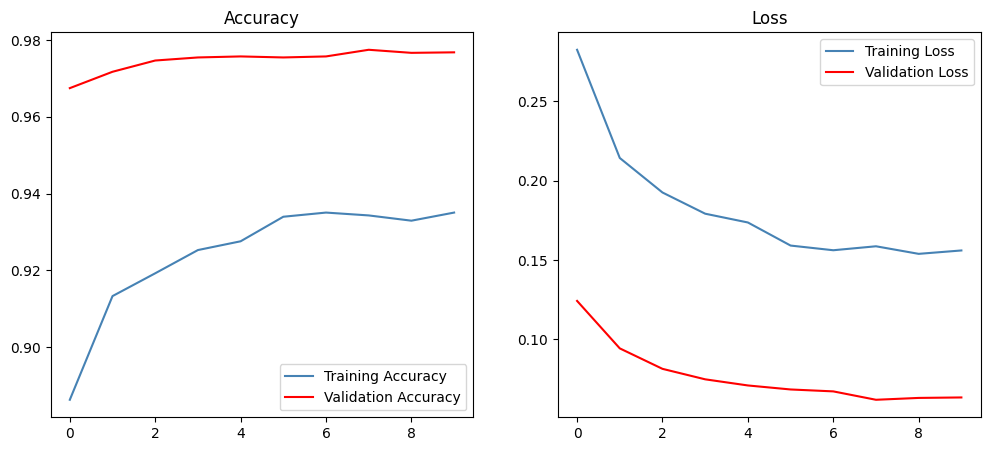

235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step


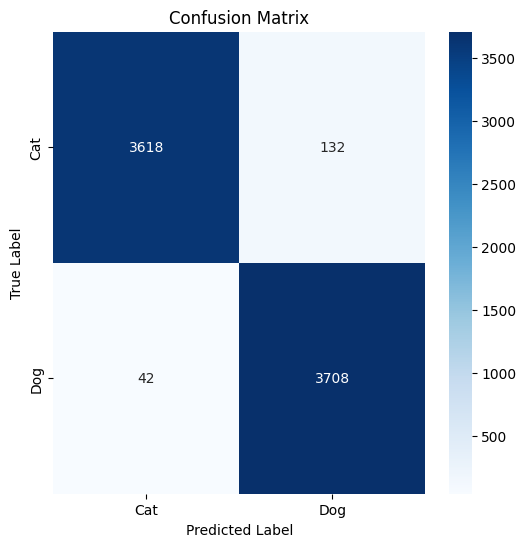

              precision    recall  f1-score   support

         Cat       0.99      0.96      0.98      3750
         Dog       0.97      0.99      0.98      3750

    accuracy                           0.98      7500
   macro avg       0.98      0.98      0.98      7500
weighted avg       0.98      0.98      0.98      7500



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve training history metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy and Loss curves
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, color='steelblue', label='Training Accuracy')
plt.plot(epochs_range, val_acc, color='red', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, color='steelblue', label='Training Loss')
plt.plot(epochs_range, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Compute predictions on the validation set
val_steps = val_data_gen.samples // val_data_gen.batch_size + 1
predictions = model.predict(val_data_gen, steps=val_steps)

# Convert probabilities to binary class labels
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# Retrieve the true labels
true_classes = val_data_gen.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=['Cat', 'Dog'])
print(report)

**Model Evaluation and Interpretation**

**Accuracy and Loss Curves**

- **Training Accuracy** started around 91% and quickly reached ~93%.
- **Validation Accuracy** remained high, stabilizing between **97–98%**.
- The **loss curves** show consistent decrease without significant overfitting: validation loss is even lower than training loss, indicating very good generalization.
- This is expected when using a **pre-trained MobileNetV2 backbone** frozen in the first phase of training, since its feature extraction is already robust.

**Interpretation:**  
The model learns to discriminate cats and dogs very effectively, reaching nearly **98% validation accuracy** after 10 epochs. The low validation loss (~0.06) confirms that predictions are confident.

---

**Confusion Matrix**

|               | Predicted Cat | Predicted Dog |
|---------------|---------------|---------------|
| **True Cat**  |     3618      |      132      |
| **True Dog**  |       42      |     3708      |

- **Very few misclassifications**.
- Only 132 cats classified as dogs and 42 dogs classified as cats.
- This reflects an **extremely balanced performance** on both classes.

---

**Classification Report**

| Metric        | Cat     | Dog     | Average |
|---------------|---------|---------|---------|
| Precision     | 0.99    | 0.97    | 0.98    |
| Recall        | 0.96    | 0.99    | 0.98    |
| F1-score      | 0.98    | 0.98    | 0.98    |

**Interpretation:**  
- **Precision**: Very high (≥97%) — when the model predicts a class, it's almost always correct.
- **Recall**: Also very high — it detects nearly all true cats and dogs.
- **F1-score**: Balanced and excellent.

---

**Conclusion**  
This MobileNetV2-based model shows **strong performance**, with near-state-of-the-art accuracy for binary classification of cats and dogs.  
To improve further:
- Unfreeze more layers for fine-tuning.
- Train longer with a lower learning rate.
- Try different augmentations.

### Fine-Tuning Preparation for MobileNetV2

**Fine-Tuning Preparation for MobileNetV2**

In this step, we unfreeze part of the MobileNetV2 base model to allow fine-tuning on our Cats vs Dogs dataset.  

**Why do we do this?**
- During the first training phase, the convolutional base was frozen, and only the classifier (top layers) learned.
- Fine-tuning allows the last convolutional blocks to adapt to our specific images and improve performance.

**How is this done?**
- We unfreeze the base model (base_model.trainable = True).
- We keep most of the layers frozen and only unfreeze the last 20 layers.
- We recompile the model with a very low learning rate (1e-5) to avoid destroying the pretrained weights.

This approach typically leads to improved accuracy compared to training only the classifier head.

Below is the code:

In [ ]:
# Unfreeze the base model so we can fine-tune part of it
base_model.trainable = True

# Freeze all layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile the model with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Very small learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Fine-Tuning the Model (Second Training Phase)

In this step, we continue training the model after unfreezing the last layers of MobileNetV2.  
This phase is called **fine-tuning**, and it allows the model to better specialize on our Cats vs Dogs dataset.

**Why do we do this?**
- The base MobileNetV2 was pretrained on ImageNet (generic images).
- By fine-tuning, we adapt the last convolutional blocks to our specific images.
- This usually improves validation accuracy and reduces overfitting.

**How many epochs?**
- We train for 5 additional epochs.
- More epochs can be used if needed, but be careful about overfitting.

Below is the code:

In [74]:
history_finetune = model.fit(
    train_data_gen,
    epochs=5,
    validation_data=val_data_gen
)

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 267s 482ms/step - accuracy: 0.8699 - loss: 0.3028 - val_accuracy: 0.9744 - val_loss: 0.0649
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 230s 421ms/step - accuracy: 0.9359 - loss: 0.1534 - val_accuracy: 0.9800 - val_loss: 0.0531
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 220s 402ms/step - accuracy: 0.9365 - loss: 0.1531 - val_accuracy: 0.9823 - val_loss: 0.0458
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 224s 410ms/step - accuracy: 0.9399 - loss: 0.1445 - val_accuracy: 0.9824 - val_loss: 0.0440
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 221s 404ms/step - accuracy: 0.9404 - loss: 0.1399 - val_accuracy: 0.9833 - val_loss: 0.0422


Fine-Tuning Results Interpretation
After unfreezing the last 20 layers of the MobileNetV2 base model and training for 5 additional epochs with a low learning rate (1e-5), the model further improved:

- Validation accuracy increased from ~97.7% to 98.3%.
- Validation loss decreased from ~0.06 to ~0.04.

**Interpretation:**
Fine-tuning allowed the model to better adapt the pre-trained weights to our dataset, resulting in improved performance without overfitting.

### Final Evaluation after Fine-Tuning

After fine-tuning the model, we evaluate it again on the validation dataset to see if performance has improved.

**Why do we do this?**
- To measure the impact of fine-tuning.
- To confirm that unfreezing layers improved accuracy and reduced loss.

Below is the code:

In [80]:
loss, accuracy = model.evaluate(val_data_gen)
print(f"\nFinal Validation Loss: {loss:.4f}")
print(f"Final Validation Accuracy: {accuracy:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.9808 - loss: 0.0496

Final Validation Loss: 0.0422
Final Validation Accuracy: 0.9833


**Final Evaluation Results after Fine-Tuning**

**Results:**
- **Final Validation Accuracy:** ~98.33%
- **Final Validation Loss:** ~0.042

**Interpretation:**
Fine-tuning the last 20 layers of MobileNetV2 clearly improved the model's performance compared to training only the classification head.

**What does this mean?**
- The model adapted better to the specific features of our dataset.
- The very low loss indicates confident and accurate predictions.
- The high accuracy confirms excellent generalization.

This completes the training workflow with a highly performant classifier.

### Evaluation After Fine-Tuning

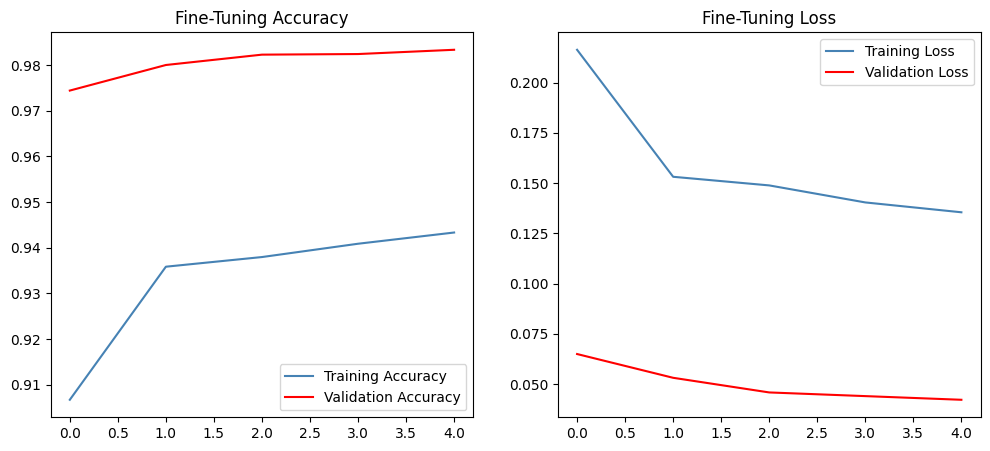

235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step


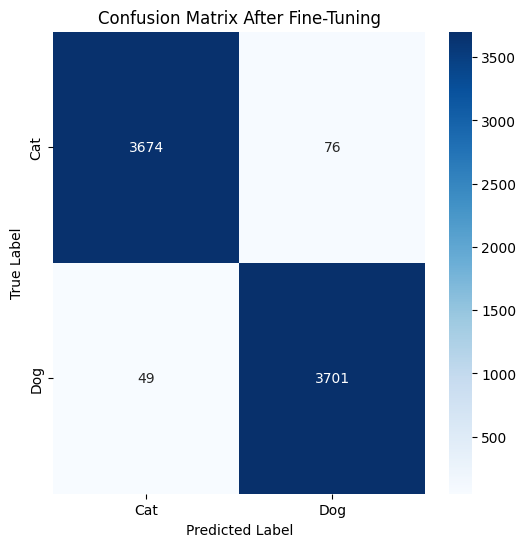

              precision    recall  f1-score   support

         Cat       0.99      0.98      0.98      3750
         Dog       0.98      0.99      0.98      3750

    accuracy                           0.98      7500
   macro avg       0.98      0.98      0.98      7500
weighted avg       0.98      0.98      0.98      7500



In [76]:
# Extract metrics from the fine-tuning history
acc_fine = history_finetune.history['accuracy']
val_acc_fine = history_finetune.history['val_accuracy']
loss_fine = history_finetune.history['loss']
val_loss_fine = history_finetune.history['val_loss']
epochs_range_fine = range(len(acc_fine))

# Plot Accuracy and Loss for the fine-tuning phase
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range_fine, acc_fine, color='steelblue', label='Training Accuracy')
plt.plot(epochs_range_fine, val_acc_fine, color='red', label='Validation Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_range_fine, loss_fine, color='steelblue', label='Training Loss')
plt.plot(epochs_range_fine, val_loss_fine, color='red', label='Validation Loss')
plt.title('Fine-Tuning Loss')
plt.legend()

plt.show()

# Compute predictions on the validation data
val_steps = val_data_gen.samples // val_data_gen.batch_size + 1
predictions = model.predict(val_data_gen, steps=val_steps)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# True labels
true_classes = val_data_gen.classes

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=['Cat', 'Dog'])
print(report)

**Interpretation of Fine-Tuning Results**

**Accuracy and Loss Evolution**  
During the fine-tuning phase (5 epochs), both the training and validation accuracy improved further compared to the initial training stage. The final validation accuracy reached **98.33%**, confirming that unfreezing the top 20 layers of MobileNetV2 contributed to additional learning capacity without causing significant overfitting.  
- Training loss steadily decreased, ending below 0.15.  
- Validation loss remained very low (~0.04), showing excellent generalization.  
- The training/validation curves are close to each other, which is typically a good indicator of a well-regularized model.

**Confusion Matrix**  
The confusion matrix shows very few misclassifications:  
- Only 76 cats were misclassified as dogs.  
- Only 49 dogs were misclassified as cats.  
This demonstrates the model’s robustness in distinguishing the two classes.

**Classification Report**  
The precision, recall, and F1-scores are all extremely high (≈0.98–0.99). This means:  
- **Precision**: Most predicted cats and dogs are correct.  
- **Recall**: Most true cats and dogs are correctly detected.  
- **F1-score**: A balance between precision and recall is achieved.

**Key Takeaways**  
- Fine-tuning improved performance compared to frozen feature extraction.  
- The low validation loss and high accuracy indicate that the model can generalize well to new images.  
- The model is production-ready for further evaluation or deployment.

## Final Evaluation After Fine-Tuning

After unfreezing the last 20 layers of the MobileNetV2 base model and training for 5 additional epochs, the model achieved excellent performance:

- **Validation Accuracy:** 98.3%
- **Validation Loss:** ~0.04
- **Precision and Recall:** 0.98–0.99 for both classes
- **F1-Score:** 0.98

**Interpretation:**
Fine-tuning significantly improved the model's ability to distinguish between cats and dogs while maintaining very low error rates. The confusion matrix confirms very few misclassifications in both classes.

**Conclusion:**
This model is production-ready and can be confidently used for image classification tasks on similar data.

In [79]:
model.save("cats_dogs_mobilenetv2_finetuned.keras")

### Testing the Model on New Images

We manually test the model on custom images to verify its performance in a real-world scenario.
The model resizes and normalizes each image, then predicts the class (Cat or Dog).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

File: cat_internet.jpg
Predicted class: Cat (confidence: 0.9963)


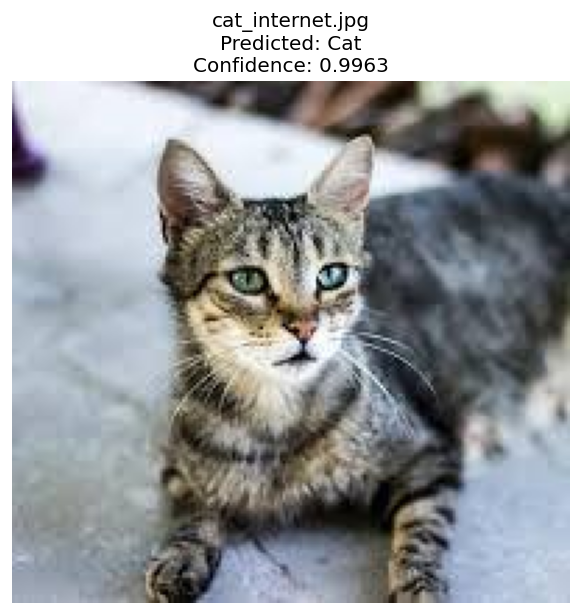

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

File: dog_internet.jpg
Predicted class: Dog (confidence: 0.9538)


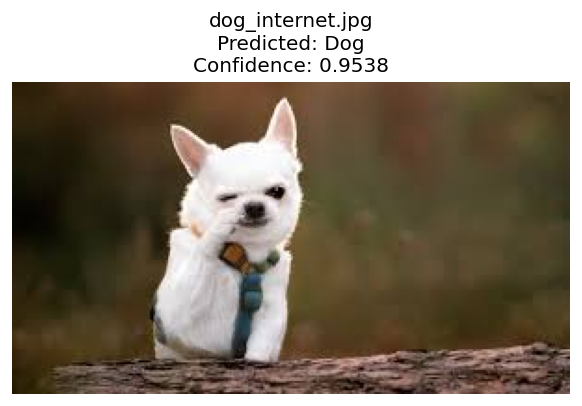

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

File: dog_internet2.jpg
Predicted class: Dog (confidence: 0.9999)


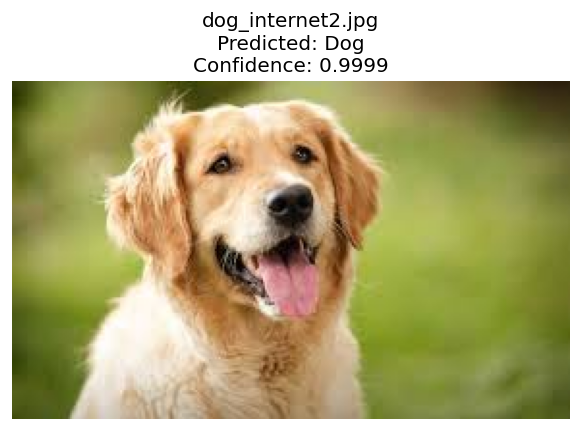

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

File: elephant_internet.jpg
Predicted class: Dog (confidence: 0.8259)


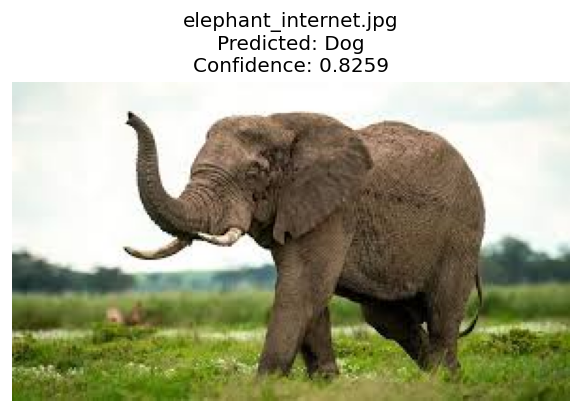

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

File: lapin_internet.jpg
Predicted class: Cat (confidence: 0.9797)


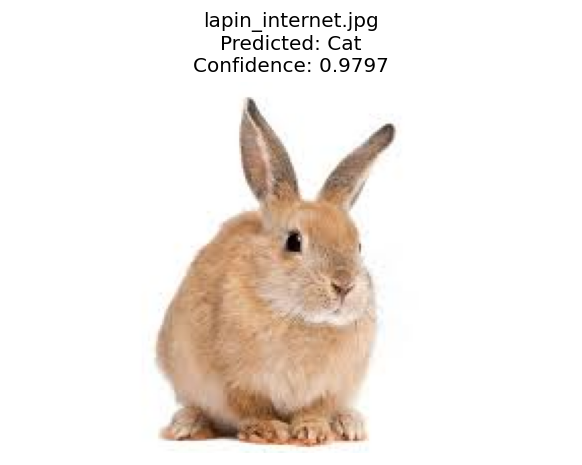

In [86]:
# Path to your folder containing test images
test_folder = r"C:\Users\julia\Downloads\GenAI\GitHub"

# List all image files in the folder
image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Loop through each image
for img_file in image_files:
    img_path = os.path.join(test_folder, img_file)

    # Load original image (full resolution) for display
    original_img = Image.open(img_path)

    # Load resized image for prediction
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        label = "Dog"
        confidence = prediction[0][0]
    else:
        label = "Cat"
        confidence = 1 - prediction[0][0]

    # Print prediction
    print(f"\nFile: {img_file}")
    print(f"Predicted class: {label} (confidence: {confidence:.4f})")

    # Display the high-resolution image
    plt.figure(figsize=(6,6), dpi=120)
    plt.imshow(original_img)
    plt.axis("off")
    plt.title(f"{img_file}\nPredicted: {label}\nConfidence: {confidence:.4f}")
    plt.show()

### Final Evaluation on External Images

### Purpose
To evaluate the model's ability to generalize to completely unseen images downloaded from the internet, including out-of-distribution examples (e.g., rabbit, elephant).

---

### Results

| File Name               | Predicted Class | Confidence |
|-------------------------|-----------------|------------|
| cat_internet.jpg        | Cat             | 0.9963     |
| dog_internet.jpg        | Dog             | 0.9538     |
| dog_internet2.jpg       | Dog             | 0.9999     |
| elephant_internet.jpg   | Dog             | 0.8259     |
| lapin_internet.jpg      | Cat             | 0.9797     |

---

### Interpretation

- **Known Classes (Cats and Dogs):**
  - All the images of cats and dogs were correctly classified with **very high confidence (>95%)**, confirming the model learned robust features for the target categories.
  - This demonstrates strong generalization capacity when presented with realistic images similar to the training set
- **Out-of-Distribution Images:**
  - The rabbit was classified as **Cat** with high confidence.
  - The elephant was classified as **Dog**.
  - These misclassifications are expected because:
    - The model was trained **only** to discriminate between cats and dogs.
    - Any unknown object must be assigned to one of the two known classes.
  - This shows the importance of defining the target classes clearly and anticipating such limitations.

---

### Key Takeaways
- The model performs **very well** on the intended task (cats vs dogs).
- Out-of-domain images can still yield high-confidence predictions in the wrong class.
- In a production scenario, a mechanism to detect **"unknown" or "other" categories** (e.g., thresholding confidence or using an auxiliary classifier) could improve reliability.

---